### make meta features using magnetic shielding data only available for train set

In [1]:
import sys
sys.path.insert(0, "/home/kohei3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/")

import numpy as np
import pandas as pd
import feather
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
features = [
        "Atom",
        "AtomPosition",
        "AtomDistance",
        "CouplingType",
        "AtomEnvironment",
        "AtomNeighbors",
        "BruteForce",
        "ScalarCouplingContributionsOof2",
        "DistanceFromClosest",
        "ElectroNegFromClosest",
        "ACSF"]

In [3]:
X_train = pd.concat([feather.read_dataframe("../features/" + feature + "_train.feather") for feature in features], axis=1)
X_test = pd.concat([feather.read_dataframe("../features/" + feature + "_test.feather") for feature in features], axis=1)

### a0, a1のみの原子ごとの特徴のみを取り出して電荷予測の特徴として用いる

In [4]:
train = feather.read_dataframe('../data/input/train.feather')
test = feather.read_dataframe('../data/input/test.feather')

In [5]:
train.shape, test.shape

((4658147, 6), (2505542, 5))

In [6]:
X_train.shape, X_test.shape

((4658147, 435), (2505542, 435))

In [7]:
X_train = pd.concat([X_train, train], axis=1)
X_test = pd.concat([X_test, test], axis=1)

In [8]:
struc = feather.read_dataframe('../data/input/structures.feather')
struc.head(20)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602


In [9]:
train.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548
7,7,dsgdb9nsd_000001,3,0,1JHC,84.8093
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.2543
9,9,dsgdb9nsd_000001,4,0,1JHC,84.8095


In [10]:
############somethigs wrong
def map_atom_info(df, atom_idx):
    df = pd.merge(df, struc, how='left', left_on=['molecule_name', f'atom_index_{atom_idx}'],
                  right_on=['molecule_name', 'atom_index'])
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}'})
    return df

train = map_atom_info(train, 0)

In [11]:
train.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x,y,z
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541,H,1.011731,1.463751,0.000277
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548,H,1.011731,1.463751,0.000277
7,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.2543,H,-0.540815,1.447527,-0.876644
9,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397


In [12]:
train = map_atom_info(train, 1)

In [13]:
train.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_x,y_x,z_x,atom_1,x_y,y_y,z_y
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541,H,1.011731,1.463751,0.000277,H,-0.540815,1.447527,-0.876644
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548,H,1.011731,1.463751,0.000277,H,-0.523814,1.437933,0.906397
7,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.2543,H,-0.540815,1.447527,-0.876644,H,-0.523814,1.437933,0.906397
9,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001


In [14]:
X_train

,atom_0,atom_1,x_0,x_1,y_0,y_1,z_0,z_1,atom_distance,type,...,acsf_121_a1,acsf_122_a1,acsf_123_a1,acsf_124_a1,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,H,C,0.002150,-0.012698,-0.006031,1.085804,0.001976,0.008001,1.544255,1JHC,...,0.0,0.0,0.0,0.0,0,dsgdb9nsd_000001,1,0,1JHC,84.807600
1,H,H,0.002150,1.011731,-0.006031,1.463751,0.001976,0.000277,2.521712,2JHH,...,0.0,0.0,0.0,0.0,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000
2,H,H,0.002150,-0.540815,-0.006031,1.447527,0.001976,-0.876644,2.521751,2JHH,...,0.0,0.0,0.0,0.0,2,dsgdb9nsd_000001,1,3,2JHH,-11.254800
3,H,H,0.002150,-0.523814,-0.006031,1.437933,0.001976,0.906397,2.521764,2JHH,...,0.0,0.0,0.0,0.0,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300
4,H,C,1.011731,-0.012698,1.463751,1.085804,0.000277,0.008001,1.544253,1JHC,...,0.0,0.0,0.0,0.0,4,dsgdb9nsd_000001,2,0,1JHC,84.807400
5,H,H,1.011731,-0.540815,1.463751,1.447527,0.000277,-0.876644,2.521766,2JHH,...,0.0,0.0,0.0,0.0,5,dsgdb9nsd_000001,2,3,2JHH,-11.254100
6,H,H,1.011731,-0.523814,1.463751,1.437933,0.000277,0.906397,2.521753,2JHH,...,0.0,0.0,0.0,0.0,6,dsgdb9nsd_000001,2,4,2JHH,-11.254800
7,H,C,-0.540815,-0.012698,1.447527,1.085804,-0.876644,0.008001,1.544245,1JHC,...,0.0,0.0,0.0,0.0,7,dsgdb9nsd_000001,3,0,1JHC,84.809300
8,H,H,-0.540815,-0.523814,1.447527,1.437933,-0.876644,0.906397,2.521752,2JHH,...,0.0,0.0,0.0,0.0,8,dsgdb9nsd_000001,3,4,2JHH,-11.254300
9,H,C,-0.523814,-0.012698,1.437933,1.085804,0.906397,0.008001,1.544247,1JHC,...,0.0,0.0,0.0,0.0,9,dsgdb9nsd_000001,4,0,1JHC,84.809500


In [15]:
a0_cols = [col for col in X_train.columns if (col in ['atom_0', 'x_0', 'y_0', 'z_0'])
                                       or ('a0_neighbor' in col)
                                       or ('dist_from' in col and 'a0' in col)
                                       or ('en_from' in col and 'a0' in col)
                                       or ('acsf' in col and 'a0' in col)]

a1_cols = [col for col in X_train.columns if (col in ['atom_1', 'x_1', 'y_1', 'z_1'])
                                       or ('a1_neighbor' in col)
                                       or ('dist_from' in col and 'a1' in col)
                                       or ('en_from' in col and 'a1' in col)
                                       or ('acsf' in col and 'a1' in col)]

assert len(a0_cols) == len(a1_cols)

In [16]:
magnet = feather.read_dataframe("../data/input/magnetic_shielding_tensors.feather")
magnet.shape

(1533537, 11)

In [17]:
magnet.head(20)

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.3150,0.0000,-0.0001,0.0000,195.3170,0.0007,-0.0001,0.0007,195.3170
1,dsgdb9nsd_000001,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
2,dsgdb9nsd_000001,2,31.5814,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967
3,dsgdb9nsd_000001,3,31.5172,4.1086,1.2723,4.1088,33.9068,1.6950,1.2724,1.6951,28.9579
4,dsgdb9nsd_000001,4,31.4029,-4.0942,-1.1793,-4.0944,34.0776,1.6259,-1.1795,1.6260,28.9013
5,dsgdb9nsd_000002,0,275.6350,0.0003,0.0133,0.0003,275.6360,-0.0003,0.0161,-0.0004,237.4970
6,dsgdb9nsd_000002,1,31.2593,5.6126,-2.1025,5.6136,37.4364,-3.5567,-2.4461,-4.1372,27.9884
7,dsgdb9nsd_000002,2,31.0341,-5.4827,-2.0299,-5.4837,37.6618,3.5987,-2.3616,4.1861,27.9885
8,dsgdb9nsd_000002,3,40.7507,-0.1300,4.1318,-0.1300,27.9413,-0.0419,4.8083,-0.0488,27.9889
9,dsgdb9nsd_000003,0,310.0960,0.0000,0.0000,0.0000,355.7730,0.0000,0.0000,0.0000,324.1550


In [18]:
# https://www.kaggle.com/tonyyy/schnet-magnetic-shielding

x = magnet.columns.values[2:]
x = magnet[x].values
x = x.reshape(-1,3,3)
x = x + np.transpose(x,(0,2,1))
x = 0.5 * x
w, v = np.linalg.eigh(x)

sigma_iso = np.sum(w, axis=1)/3 
omega = w[:,2] - w[:,0]
kappa = 3 * (sigma_iso - w[:,1])/omega

magnet = magnet[magnet.columns.values[:2]]
magnet = pd.DataFrame(magnet)
magnet["sigma_iso"] = sigma_iso
magnet["omega"] = omega
magnet["kappa"] = kappa

magnet.head(10)

,molecule_name,atom_index,sigma_iso,omega,kappa
0,dsgdb9nsd_000001,0,195.316333,0.002708,0.032697
1,dsgdb9nsd_000001,1,31.460567,9.082838,0.999975
2,dsgdb9nsd_000001,2,31.460567,9.082793,0.999984
3,dsgdb9nsd_000001,3,31.460633,9.082804,0.999977
4,dsgdb9nsd_000001,4,31.460600,9.082853,0.999971
5,dsgdb9nsd_000002,0,262.922667,38.139089,-0.999939
6,dsgdb9nsd_000002,1,32.228033,15.583995,0.825251
7,dsgdb9nsd_000002,2,32.228133,15.584143,0.825259
8,dsgdb9nsd_000002,3,32.226967,15.583030,0.825318
9,dsgdb9nsd_000003,0,330.008000,45.677000,0.384417


In [19]:
X_magnet_a0 = X_train.groupby(['molecule_name', 'atom_index_0']).first()[a0_cols].reset_index()

In [20]:
X_magnet_a0.columns = ['molecule_name', 'atom_index'] + [f'col_{i}' for i in range(180)]

In [21]:
X_magnet_a1 = X_train.groupby(['molecule_name', 'atom_index_1']).first()[a1_cols].reset_index()
X_magnet_a1.columns = ['molecule_name', 'atom_index'] + [f'col_{i}' for i in range(180)]

In [22]:
X_magnet = pd.concat([X_magnet_a0, X_magnet_a1], axis=0).drop_duplicates(keep='first')

In [23]:
X_magnet.shape

(1405126, 182)

In [24]:
X_magnet.head(20)

,molecule_name,atom_index,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,...,col_170,col_171,col_172,col_173,col_174,col_175,col_176,col_177,col_178,col_179
0,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,dsgdb9nsd_000003,1,H,0.064766,0.020572,0.001535,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,dsgdb9nsd_000005,2,H,-0.027803,2.198949,0.014154,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,dsgdb9nsd_000007,2,H,0.994873,1.939743,0.002941,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
magnet = magnet.merge(X_magnet, on=['molecule_name', 'atom_index'], how='left')

In [26]:
magnet.head(30)

,molecule_name,atom_index,sigma_iso,omega,kappa,col_0,col_1,col_2,col_3,col_4,...,col_170,col_171,col_172,col_173,col_174,col_175,col_176,col_177,col_178,col_179
0,dsgdb9nsd_000001,0,195.316333,0.002708,0.032697,C,-0.012698,1.085804,0.008001,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dsgdb9nsd_000001,1,31.460567,9.082838,0.999975,H,0.002150,-0.006031,0.001976,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dsgdb9nsd_000001,2,31.460567,9.082793,0.999984,H,1.011731,1.463751,0.000277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dsgdb9nsd_000001,3,31.460633,9.082804,0.999977,H,-0.540815,1.447527,-0.876644,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dsgdb9nsd_000001,4,31.460600,9.082853,0.999971,H,-0.523814,1.437933,0.906397,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,dsgdb9nsd_000002,0,262.922667,38.139089,-0.999939,N,-0.040426,1.024108,0.062564,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,dsgdb9nsd_000002,1,32.228033,15.583995,0.825251,H,0.017257,0.012545,-0.027377,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,dsgdb9nsd_000002,2,32.228133,15.584143,0.825259,H,0.915789,1.358745,-0.028758,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,dsgdb9nsd_000002,3,32.226967,15.583030,0.825318,H,-0.520278,1.343532,-0.775543,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,dsgdb9nsd_000003,0,330.008000,45.677000,0.384417,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#全部NaNのはそもそもtrainに出てこない原子なので落とす
drop_cols = magnet['col_0'].isnull() 
magnet = magnet[~drop_cols]
magnet.shape

(1405126, 185)

In [28]:
X_magnet_a0_te = X_test.groupby(['molecule_name', 'atom_index_0']).first()[a0_cols].reset_index()
X_magnet_a0_te.columns = ['molecule_name', 'atom_index'] + [f'col_{i}' for i in range(180)]
X_magnet_a1_te = X_test.groupby(['molecule_name', 'atom_index_1']).first()[a1_cols].reset_index()
X_magnet_a1_te.columns = ['molecule_name', 'atom_index'] + [f'col_{i}' for i in range(180)]
X_magnet_te = pd.concat([X_magnet_a0_te, X_magnet_a1_te], axis=0).drop_duplicates(keep='first')

X_magnet_te.head(30)

,molecule_name,atom_index,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,...,col_170,col_171,col_172,col_173,col_174,col_175,col_176,col_177,col_178,col_179
0,dsgdb9nsd_000004,2,H,-1.661639,0.000000,1.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dsgdb9nsd_000004,3,H,1.661639,0.000000,1.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dsgdb9nsd_000015,3,H,1.005284,1.810158,0.004656,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dsgdb9nsd_000015,4,H,-0.546896,1.793435,-0.872511,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dsgdb9nsd_000015,5,H,-0.530029,1.722920,0.911017,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,dsgdb9nsd_000015,6,H,0.139938,-0.255993,-2.050984,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,dsgdb9nsd_000015,7,H,1.692653,-0.238684,-1.174777,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,dsgdb9nsd_000015,8,H,0.599594,-1.641802,-1.024076,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,dsgdb9nsd_000016,3,H,-0.305415,2.017021,0.925332,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,dsgdb9nsd_000016,4,H,-0.322755,2.026802,-0.893478,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
magnet.shape

(1405126, 185)

In [30]:
X_magnet_te.shape

(756113, 182)

In [31]:
magnet.head()

,molecule_name,atom_index,sigma_iso,omega,kappa,col_0,col_1,col_2,col_3,col_4,...,col_170,col_171,col_172,col_173,col_174,col_175,col_176,col_177,col_178,col_179
0,dsgdb9nsd_000001,0,195.316333,0.002708,0.032697,C,-0.012698,1.085804,0.008001,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dsgdb9nsd_000001,1,31.460567,9.082838,0.999975,H,0.002150,-0.006031,0.001976,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dsgdb9nsd_000001,2,31.460567,9.082793,0.999984,H,1.011731,1.463751,0.000277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dsgdb9nsd_000001,3,31.460633,9.082804,0.999977,H,-0.540815,1.447527,-0.876644,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dsgdb9nsd_000001,4,31.460600,9.082853,0.999971,H,-0.523814,1.437933,0.906397,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#magnet['col_0'].fillna('H', inplace=True)
#X_magnet_te['col_0'].fillna('H', inplace=True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
magnet['col_0'] = le.fit_transform(magnet['col_0'])
X_magnet_te['col_0'] = le.transform(X_magnet_te['col_0'])

In [33]:
train_iso_oof = np.zeros(len(magnet))
test_iso_pred = np.zeros(len(X_magnet_te))


kf = GroupKFold(n_splits=2)

target = magnet['sigma_iso']

cols = [col for col in magnet.columns if 'col_' in col]

SEED = 42
NUM_ROUNDS = 10000

params = {
        "num_leaves": 90,
        "min_data_in_leaf": 100,
        "objective": "regression",
        "max_depth": 8,
        "learning_rate": 0.2,
        "boosting_type": "gbdt",
        "subsample_freq": 1,
        "subsample": 0.9,
        "metric": "mae",
        "reg_alpha": 0.1,
        "reg_lambda": 0.3, 
        "colsample_bytree": 0.9
        }

for train_idx, val_idx in kf.split(magnet, groups=magnet['molecule_name']):
        train_data = lgb.Dataset(magnet[cols].iloc[train_idx], label=target.iloc[train_idx])
        val_data = lgb.Dataset(magnet[cols].iloc[val_idx], label=target.iloc[val_idx])
        clf = lgb.train(params, train_data, NUM_ROUNDS, valid_sets=[train_data, val_data],
                        verbose_eval=1000, early_stopping_rounds=100)
        train_iso_oof[val_idx] = clf.predict(magnet[cols].iloc[val_idx], num_iteration=clf.best_iteration)
        test_iso_pred += clf.predict(X_magnet_te[cols], num_iteration=clf.best_iteration) / kf.n_splits

Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 0.96541	valid_1's l1: 1.33049
[2000]	training's l1: 0.710263	valid_1's l1: 1.23109
[3000]	training's l1: 0.56014	valid_1's l1: 1.18927
[4000]	training's l1: 0.45825	valid_1's l1: 1.16535
[5000]	training's l1: 0.382479	valid_1's l1: 1.14925
[6000]	training's l1: 0.324199	valid_1's l1: 1.13809
[7000]	training's l1: 0.278225	valid_1's l1: 1.13005
[8000]	training's l1: 0.240862	valid_1's l1: 1.12396
[9000]	training's l1: 0.210307	valid_1's l1: 1.11923
[10000]	training's l1: 0.184313	valid_1's l1: 1.11571
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.184313	valid_1's l1: 1.11571
Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 0.973609	valid_1's l1: 1.32692
[2000]	training's l1: 0.71784	valid_1's l1: 1.22817
[3000]	training's l1: 0.567037	valid_1's l1: 1.18479
[4000]	training's l1: 0.463839	valid_1's l1: 1.15993
[5000]	training's l1: 0.386963	va

In [34]:
train_omega_oof = np.zeros(len(magnet))
test_omega_pred = np.zeros(len(X_magnet_te))


kf = GroupKFold(n_splits=2)

target = magnet['omega']

cols = [col for col in magnet.columns if 'col_' in col]

SEED = 42
NUM_ROUNDS = 10000

params = {
        "num_leaves": 90,
        "min_data_in_leaf": 100,
        "objective": "regression",
        "max_depth": 8,
        "learning_rate": 0.2,
        "boosting_type": "gbdt",
        "subsample_freq": 1,
        "subsample": 0.9,
        "metric": "mae",
        "reg_alpha": 0.1,
        "reg_lambda": 0.3, 
        "colsample_bytree": 0.9
        }

for train_idx, val_idx in kf.split(magnet, groups=magnet['molecule_name']):
        train_data = lgb.Dataset(magnet[cols].iloc[train_idx], label=target.iloc[train_idx])
        val_data = lgb.Dataset(magnet[cols].iloc[val_idx], label=target.iloc[val_idx])
        clf = lgb.train(params, train_data, NUM_ROUNDS, valid_sets=[train_data, val_data],
                        verbose_eval=1000, early_stopping_rounds=100)
        train_omega_oof[val_idx] = clf.predict(magnet[cols].iloc[val_idx], num_iteration=clf.best_iteration)
        test_omega_pred += clf.predict(X_magnet_te[cols], num_iteration=clf.best_iteration) / kf.n_splits

Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 2.10173	valid_1's l1: 2.81071
[2000]	training's l1: 1.56634	valid_1's l1: 2.60376
[3000]	training's l1: 1.24421	valid_1's l1: 2.5089
[4000]	training's l1: 1.01739	valid_1's l1: 2.45243
[5000]	training's l1: 0.851155	valid_1's l1: 2.41726
[6000]	training's l1: 0.722237	valid_1's l1: 2.39253
[7000]	training's l1: 0.621768	valid_1's l1: 2.37477
[8000]	training's l1: 0.53917	valid_1's l1: 2.36107
[9000]	training's l1: 0.47078	valid_1's l1: 2.35037
[10000]	training's l1: 0.4129	valid_1's l1: 2.34217
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.4129	valid_1's l1: 2.34217
Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 2.10687	valid_1's l1: 2.79349
[2000]	training's l1: 1.58687	valid_1's l1: 2.59496
[3000]	training's l1: 1.26699	valid_1's l1: 2.5038
[4000]	training's l1: 1.0454	valid_1's l1: 2.44945
[5000]	training's l1: 0.875057	valid_1's l1: 2

In [35]:
train_kappa_oof = np.zeros(len(magnet))
test_kappa_pred = np.zeros(len(X_magnet_te))


kf = GroupKFold(n_splits=2)

target = magnet['kappa']

cols = [col for col in magnet.columns if 'col_' in col]

SEED = 42
NUM_ROUNDS = 10000

params = {
        "num_leaves": 90,
        "min_data_in_leaf": 100,
        "objective": "regression",
        "max_depth": 8,
        "learning_rate": 0.2,
        "boosting_type": "gbdt",
        "subsample_freq": 1,
        "subsample": 0.9,
        "metric": "mae",
        "reg_alpha": 0.1,
        "reg_lambda": 0.3, 
        "colsample_bytree": 0.9
        }

for train_idx, val_idx in kf.split(magnet, groups=magnet['molecule_name']):
        train_data = lgb.Dataset(magnet[cols].iloc[train_idx], label=target.iloc[train_idx])
        val_data = lgb.Dataset(magnet[cols].iloc[val_idx], label=target.iloc[val_idx])
        clf = lgb.train(params, train_data, NUM_ROUNDS, valid_sets=[train_data, val_data],
                        verbose_eval=1000, early_stopping_rounds=100)
        train_kappa_oof[val_idx] = clf.predict(magnet[cols].iloc[val_idx], num_iteration=clf.best_iteration)
        test_kappa_pred += clf.predict(X_magnet_te[cols], num_iteration=clf.best_iteration) / kf.n_splits

Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 0.0857234	valid_1's l1: 0.105915
[2000]	training's l1: 0.0671093	valid_1's l1: 0.0990559
[3000]	training's l1: 0.0551938	valid_1's l1: 0.0958865
[4000]	training's l1: 0.0463674	valid_1's l1: 0.0939596
[5000]	training's l1: 0.039584	valid_1's l1: 0.0927301
[6000]	training's l1: 0.0341168	valid_1's l1: 0.0918709
[7000]	training's l1: 0.0296123	valid_1's l1: 0.0912317
[8000]	training's l1: 0.0258695	valid_1's l1: 0.0907647
[9000]	training's l1: 0.0227348	valid_1's l1: 0.0903975
[10000]	training's l1: 0.0200369	valid_1's l1: 0.0901081
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.0200369	valid_1's l1: 0.0901081
Training until validation scores don't improve for 100 rounds.
[1000]	training's l1: 0.084918	valid_1's l1: 0.105535
[2000]	training's l1: 0.066761	valid_1's l1: 0.099064
[3000]	training's l1: 0.0549988	valid_1's l1: 0.0958922
[4000]	training's l1: 0.0462332	valid_1's l1: 

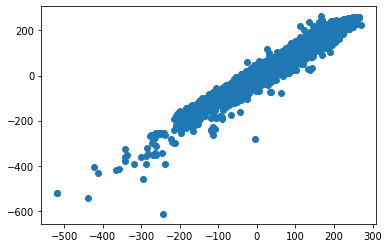

In [36]:
plt.plot(train_iso_oof, magnet['sigma_iso'], 'o')
plt.show()

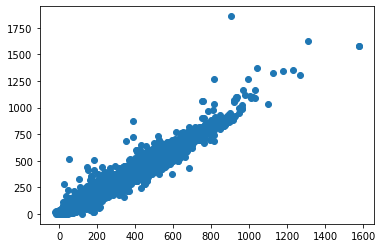

In [37]:
plt.plot(train_omega_oof, magnet['omega'], 'o')
plt.show()

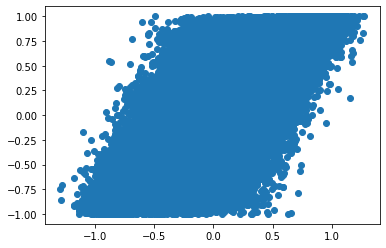

In [38]:
plt.plot(train_kappa_oof, magnet['kappa'], 'o')
plt.show()

In [39]:
magnet_train = magnet[['molecule_name', 'atom_index']]
magnet_train['iso_pred'] = train_iso_oof
magnet_train['omega_pred'] = train_omega_oof
magnet_train['kappa_pred'] = train_kappa_oof


magnet_test = X_magnet_te[['molecule_name', 'atom_index']]
magnet_test['iso_pred'] = test_iso_pred
magnet_test['omega_pred'] = test_omega_pred
magnet_test['kappa_pred'] = test_kappa_pred

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [40]:
magnet_train.head()

,molecule_name,atom_index,iso_pred,omega_pred,kappa_pred
0,dsgdb9nsd_000001,0,153.450236,119.535083,0.569605
1,dsgdb9nsd_000001,1,35.447341,56.394287,0.543032
2,dsgdb9nsd_000001,2,35.471423,50.248142,0.542499
3,dsgdb9nsd_000001,3,36.553298,47.025558,0.566099
4,dsgdb9nsd_000001,4,36.999652,48.727129,0.497633


In [41]:
magnet_test.head()

,molecule_name,atom_index,iso_pred,omega_pred,kappa_pred
0,dsgdb9nsd_000004,2,48.075027,38.586287,0.676868
1,dsgdb9nsd_000004,3,49.017456,41.496883,0.671444
2,dsgdb9nsd_000015,3,29.322102,5.620666,0.694874
3,dsgdb9nsd_000015,4,29.153205,7.803224,0.724271
4,dsgdb9nsd_000015,5,27.367733,10.446812,0.666959


In [42]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_x,y_x,z_x,atom_1,x_y,y_y,z_y
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


In [43]:

train = train.merge(magnet_train, left_on=['molecule_name', 'atom_index_0'], right_on=['molecule_name', 'atom_index'], how='left')
train = train.merge(magnet_train, left_on=['molecule_name', 'atom_index_1'], right_on=['molecule_name', 'atom_index'], how='left', suffixes=['_a0', '_a1'])

test = test.merge(magnet_test, left_on=['molecule_name', 'atom_index_0'], right_on=['molecule_name', 'atom_index'], how='left')
test = test.merge(magnet_test, left_on=['molecule_name', 'atom_index_1'], right_on=['molecule_name', 'atom_index'], how='left', suffixes=['_a0', '_a1'])


In [44]:
train[['iso_pred_a0', 'iso_pred_a1','omega_pred_a0', 'omega_pred_a1','kappa_pred_a0', 'kappa_pred_a1']].to_feather('../features/MagnetPred_train.feather')
test[['iso_pred_a0', 'iso_pred_a1','omega_pred_a0', 'omega_pred_a1','kappa_pred_a0', 'kappa_pred_a1']].to_feather('../features/MagnetPred_test.feather')